In [50]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image as im
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import utils
from collections import defaultdict

In [21]:
'''
TODO

[v] rebuild isomap algo
[v] baseline algo by creating top eigenface for all subjects
    [v] what is clf accuracy for each eigenface?
    [] how well does projected residual classify each face? (diff between 2 proj residuals)
[v] find 2 other dissimilarity metrics
[v] create masks on all subjects
[v] try to classify mask faces using unmasked eigenfaces
    [v] gather dissimilarity metrics
[v] create new top eigenfaces for faces partially covering face (random bottom left/right)
[v] classify mask faces using new eigenfaces
    [] classify unmasked faces using partially covered eigenfaces?
[v] center-crop faces
    [v] redo full masking
    [v] redo partial masking
[v] save dissimilarity report to df
    
!! pulse check. If I have time/bandwidth...

[v] repeat with sunglasses
[v] 10, 20, ..., 90% of face covering
    [] Random start location on face or start over nose, eyes, ears, mouth?
        [] What shape should covering be - circle (nose, mouth), square (ear, eyes)?
    [v] how does performance change with % of face covered?
    [] which feature(s) are most important?
    
'''

'\nTODO\n\n[v] rebuild isomap algo\n[v] baseline algo by creating top eigenface for all subjects\n    [v] what is clf accuracy for each eigenface?\n    [] how well does projected residual classify each face? (diff between 2 proj residuals)\n[v] find 2 other dissimilarity metrics\n[v] create masks on all subjects\n[v] try to classify mask faces using unmasked eigenfaces\n    [v] gather dissimilarity metrics\n[v] create new top eigenfaces for faces partially covering face (random bottom left/right)\n[v] classify mask faces using new eigenfaces\n    [] classify unmasked faces using partially covered eigenfaces?\n[v] center-crop faces\n    [v] redo full masking\n    [v] redo partial masking\n[v] save dissimilarity report to df\n    \n!! pulse check. If I have time/bandwidth...\n\n[v] repeat with sunglasses\n[v] 10, 20, ..., 90% of face covering\n    [] Random start location on face or start over nose, eyes, ears, mouth?\n        [] What shape should covering be - circle (nose, mouth), squa

In [22]:
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'data')
cropped_dir = os.path.join(cwd, 'cropped')

# Transform all images to PNG files
utils.turn_images_to_pngs(data_dir)

# Center-crop all images and save to cropped/ folder
utils.crop_faces(data_dir)

# Check out sample image
test_img_path = r'cropped/subject01.centerlight.png'
test_img = im.open(test_img_path)
arr = np.asarray(test_img)
m,n = arr.shape

# Read all images used for creating eigenfaces into array
base_train_arr = utils.get_train_faces(cropped_dir)

# Read all images used for creating weight vectors for each face class into array
base_truth_arr = utils.get_weight_faces(cropped_dir)

# Get all centerlight images. These will be used for facial recognition
unmasked_test_arr = utils.get_test_faces(cropped_dir)

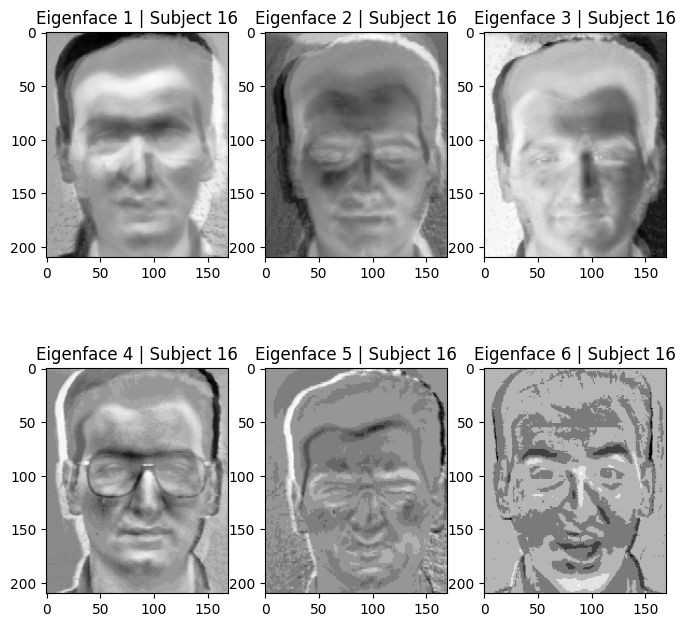

In [23]:
# Top 6 eigenfaces for each subject - UNMASKED
n_efaces = 6
n_subjects = 15
faces_per_subject = int(base_train_arr.shape[0] / n_subjects)

top_efaces = {}

for i in range(n_subjects):
    train_faces = base_train_arr[i*faces_per_subject : (i+1)*faces_per_subject]
    efaces = utils.get_top_n_eigenfaces(train_faces, n=n_efaces)
    top_efaces[i+1] = utils.normalize_data(efaces, max_=255)

# Plot some sample eigenfaces
ix = 15
efaces = top_efaces[ix]
Z = np.zeros(efaces.shape)
for i in range(efaces.shape[0]):
    Z[i,:] = efaces[i,:]
utils.plot_top_6_eigenfaces(Z, subject=ix+1)

In [24]:
# Get weight vector for each subject - represents a centered training face for each subject projected into that subject's eigenface space
base_truth_wts = utils.get_truth_weights(base_train_arr, base_truth_arr, top_efaces)

# Get avg face for each face used in training the eigenfaces
base_avg_faces = utils.get_avg_faces(base_train_arr, faces_per_subject)

# Calculate dissimilarities between each eigenface/test face combo
base_dissims = utils.calc_dissimilarities_v2(top_efaces, unmasked_test_arr, base_truth_wts, base_avg_faces)

base_accs = utils.dissims_to_df(base_dissims)

In [25]:
# NOTE: OLD IMPLEMENTATION
# # Use top eface from each subject to classify all test images using dissimilarity metrics
# sim = utils.calc_dissimilarities(top_efaces, test_arr)

# accs = utils.clf_accs_to_df(sim)

In [26]:
# Create fully masked faces
# pic_paths = [os.path.join(cwd, 'cropped', pic) for pic in os.listdir(cropped_dir)]
# for pp in pic_paths:
#     utils.add_full_facemask(pp)

# Grab fully masked test faces
masked_data_dir = os.path.join(cwd, 'full_mask_faces')
masked_test_arr = utils.get_test_faces(masked_data_dir)

# Project fully masked test faces onto unmasked eigenface space for classification and gather accuracy
masked_dissims = utils.calc_dissimilarities_v2(top_efaces, masked_test_arr, base_truth_wts, base_avg_faces)
masked_accs = utils.dissims_to_df(masked_dissims)

# Masked faces are classified better in many cases. Maybe explore feature prominence for clf??

In [ ]:
# NOTE: OLD IMPLEMENTATION
# Create fully masked faces
# pic_paths = [os.path.join(cwd, 'cropped', pic) for pic in os.listdir(cropped_dir)]
# for pp in pic_paths:
#     utils.add_full_facemask(pp)

# Use top UNMASKED eface from each subject to classify all MASKED test faces
# masked_data_dir = os.path.join(cwd, 'full_mask_faces')
# test_masked_arr = utils.get_test_faces(masked_data_dir)
# sim2 = utils.calc_dissimilarities(top_efaces, test_masked_arr)

# accs2 = utils.clf_accs_to_df(sim2)

# Masked faces are classified better in many cases. Maybe explore feature prominence for clf??

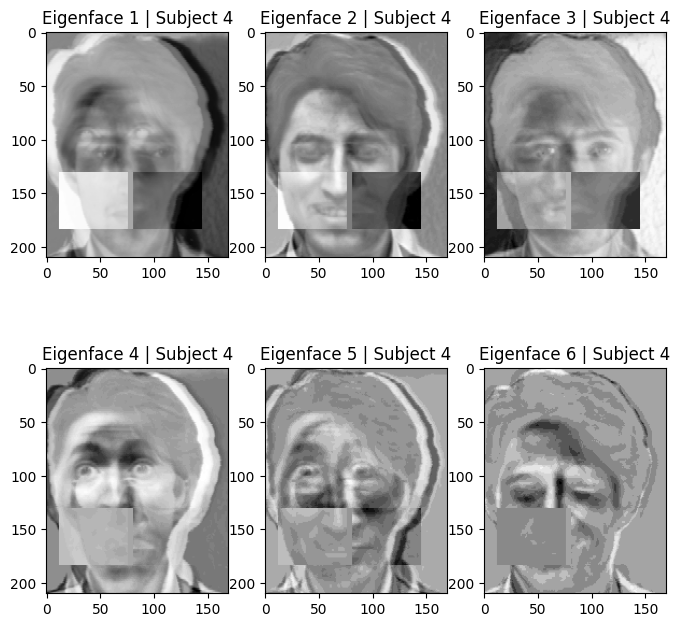

In [27]:
# Create half-masked faces
# pic_paths = [os.path.join(cwd, 'cropped', pic) for pic in os.listdir(cropped_dir)]
# for pp in pic_paths:
#     utils.add_partial_facemask(pp)

# Read all partially masked images into array
half_mask_dir = os.path.join(cwd, 'half_mask_faces')
half_mask_train_arr = utils.get_train_faces(half_mask_dir)

# Get faces used for generating "truth" weight vectors
half_mask_truth_arr = utils.get_weight_faces(half_mask_dir)

# Top 6 eigenfaces for each subject - PARTIAL MASK
n_efaces = 6
n_subjects = 15
faces_per_subject = int(half_mask_train_arr.shape[0] / n_subjects)

top_half_mask_efaces = {}

for i in range(n_subjects):
    train_faces = half_mask_train_arr[i*faces_per_subject : (i+1)*faces_per_subject]
    efaces = utils.get_top_n_eigenfaces(train_faces, n=n_efaces)
    top_half_mask_efaces[i+1] = utils.normalize_data(efaces, max_=255)

# Plot some sample half-mask eigenfaces
ix = 3
half_mask_efaces = top_half_mask_efaces[ix]
Z_halfmask = np.zeros(half_mask_efaces.shape)
for i in range(half_mask_efaces.shape[0]):
    Z_halfmask[i,:] = half_mask_efaces[i,:]
utils.plot_top_6_eigenfaces(Z_halfmask, subject=ix+1)

In [12]:
# NOTE: OLD IMPLEMENTATION
# Create half-masked faces
# pic_paths = [os.path.join(cwd, 'cropped', pic) for pic in os.listdir(cropped_dir)]
# for pp in pic_paths:
#     utils.add_partial_facemask(pp)

# # Read all partially masked images into array
# half_mask_dir = os.path.join(cwd, 'half_mask_faces')
# half_mask_train_arr = utils.get_train_faces(half_mask_dir)

# # Top 9 eigenfaces for each subject - PARTIAL MASK
# n_subjects = 15
# faces_per_subject = int(half_mask_train_arr.shape[0] / n_subjects)

# top_half_mask_efaces = {}

# for i in range(n_subjects):
#     train_faces = half_mask_train_arr[i*faces_per_subject : (i+1)*faces_per_subject]
#     efaces = utils.get_top_n_eigenfaces(train_faces, n=9)
#     top_half_mask_efaces[i+1] = efaces

# # Plot some sample half-mask eigenfaces
# ix = 3
# half_mask_efaces = top_half_mask_efaces[3]
# Z_halfmask = np.zeros(half_mask_efaces.shape)
# for i in range(half_mask_efaces.shape[0]):
#     img = half_mask_efaces[i,:]
#     Z_halfmask[i,:] = utils.normalize_data(img, max=255)
# utils.plot_top_9_eigenfaces(Z_halfmask, subject=ix+1)

TypeError: normalize_data() got an unexpected keyword argument 'max'

In [28]:
# Get weight vector for each subject - represents a centered training face for each HALF MASK subject projected into that subject's HALF MASK eigenface space
half_mask_truth_wts = utils.get_truth_weights(half_mask_train_arr, half_mask_truth_arr, top_half_mask_efaces)

# Get avg face for each face used in training the eigenfaces
half_mask_avg_faces = utils.get_avg_faces(half_mask_train_arr, faces_per_subject)

# Calculate dissimilarities between each eigenface/test face combo
half_mask_test_arr = utils.get_test_faces(half_mask_dir)
half_mask_dissims = utils.calc_dissimilarities_v2(top_half_mask_efaces, half_mask_test_arr, half_mask_truth_wts, half_mask_avg_faces)

half_mask_accs = utils.dissims_to_df(half_mask_dissims)

In [8]:
# NOTE: OLD IMPLEMENTATION
# Use top PARTIALLY-MASKED eface from each subject to classify all MASKED test faces
# sim3 = utils.calc_dissimilarities(top_half_mask_efaces, test_masked_arr)

# accs3 = utils.clf_accs_to_df(sim3)

c:\Users\611391\Documents\Learning\GA Tech OMSA\Classes\ISYE 6740\HW\.env\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


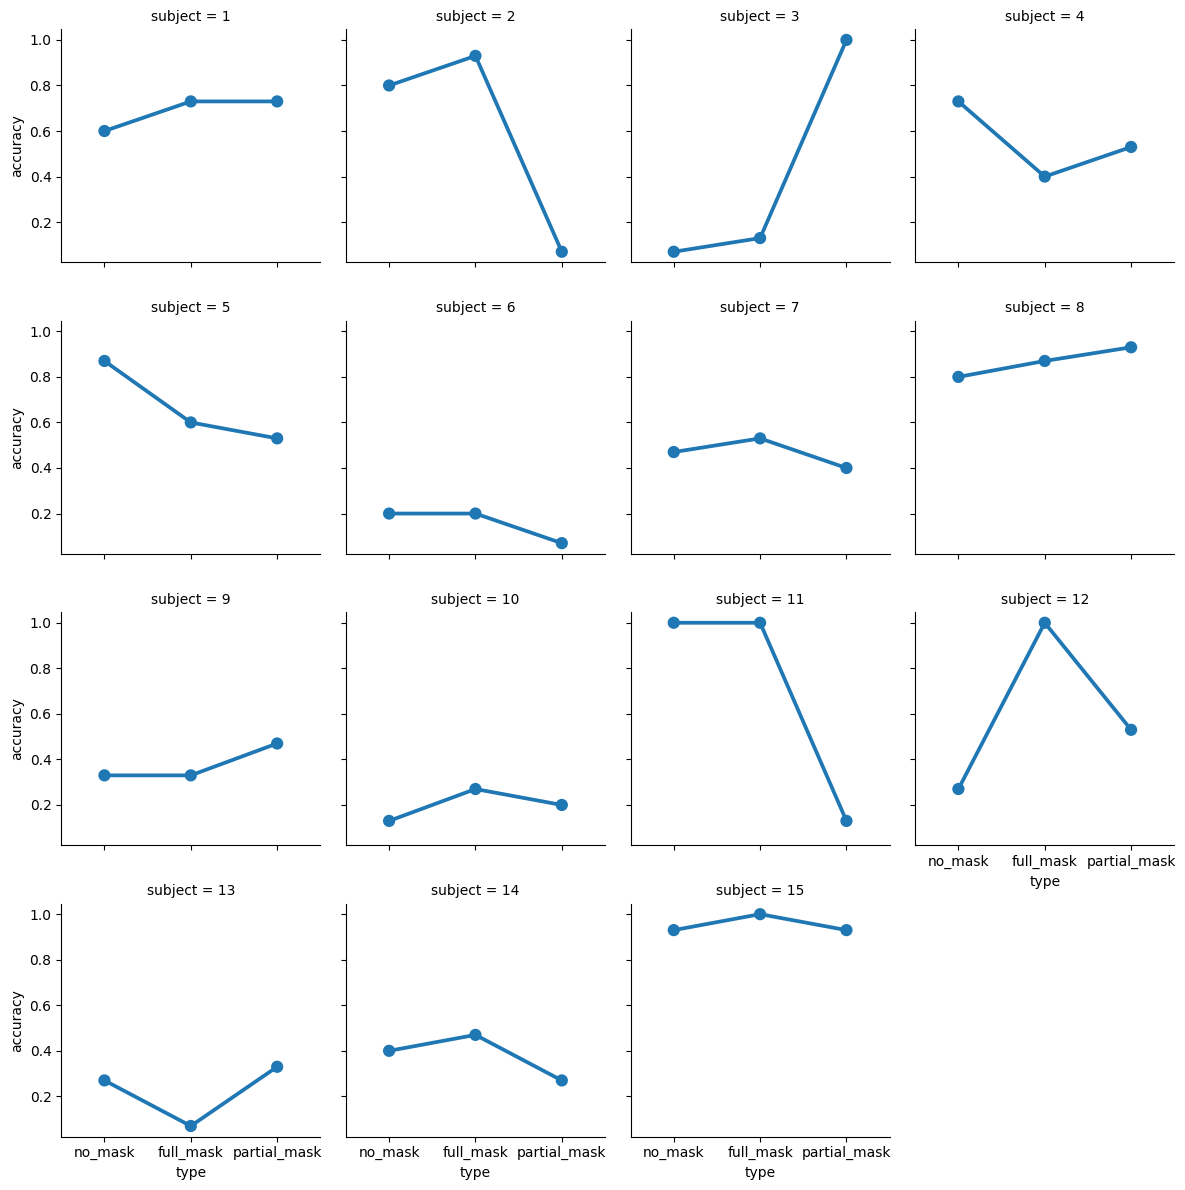

In [32]:
base_accs['type'] = 'no_mask'
masked_accs['type'] = 'full_mask'
half_mask_accs['type'] = 'partial_mask'
all_accs = pd.concat([base_accs, masked_accs, half_mask_accs]).reset_index(drop=True)

g = sns.FacetGrid(all_accs, col='subject', col_wrap=4)
g.map(sns.pointplot, 'type', 'accuracy')

In [33]:
# NOTE: OLD IMPLEMENTATION
# accs['type'] = 'no_mask'
# accs2['type'] = 'full_mask'
# accs3['type'] = 'partial_mask'
# all_accs = pd.concat([accs, accs2, accs3]).reset_index(drop=True)

# g = sns.FacetGrid(all_accs, col='subject', col_wrap=4)
# g.map(sns.pointplot, 'type', 'median_acc', color='0.3')
# g.map(sns.pointplot, 'type', 'avg_acc', color='#ff9f9b')

# # TODO: UPDATE AXES

Not much of a clear pattern. Some accs go up, others go down. Regular eigenfaces often do a better job at identifying masked faces. A similar job is done by partially masked faces. No clear improvement of partial-mask eigenfaces over unmasked eigenfaces when classifying unmasked faces.

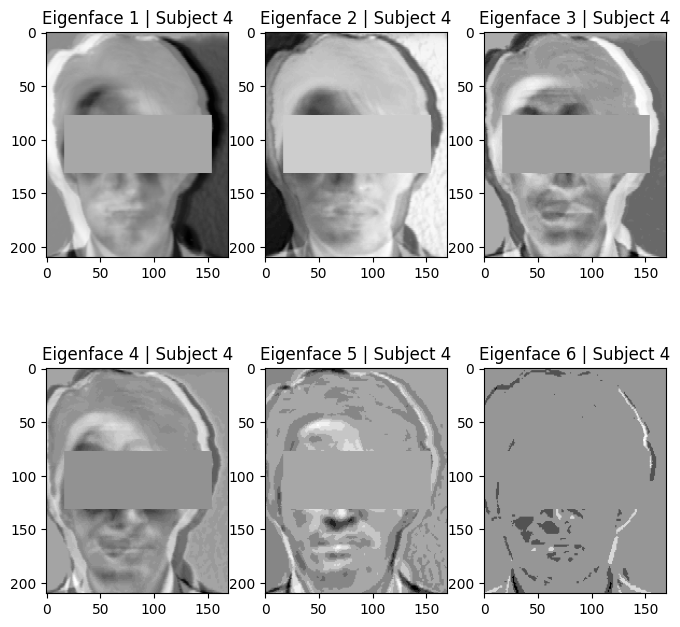

In [34]:
# Repeat analysis with sunglasses
sunglasses_dir = os.path.join(cwd, 'sunglasses_faces')

# Create sunglasses faces
# pic_paths = [os.path.join(cwd, 'cropped', pic) for pic in os.listdir(cropped_dir)]
# for pp in pic_paths:
#     utils.add_sunglasses(pp)

# Read all sunglasses images into array
sunglasses_train_arr = utils.get_train_faces(sunglasses_dir)

# Top 9 eigenfaces for each subject - SUNGLASSES
n_efaces = 6
n_subjects = 15
faces_per_subject = int(sunglasses_train_arr.shape[0] / n_subjects)

top_sunglasses_efaces = {}

for i in range(n_subjects):
    train_faces = sunglasses_train_arr[i*faces_per_subject : (i+1)*faces_per_subject]
    efaces = utils.get_top_n_eigenfaces(train_faces, n=n_efaces)
    top_sunglasses_efaces[i+1] = utils.normalize_data(efaces, max_=255)

# Plot some sample half-mask eigenfaces
ix = 3
sunglasses_efaces = top_sunglasses_efaces[3]
Z_sunglasses = np.zeros(sunglasses_efaces.shape)
for i in range(sunglasses_efaces.shape[0]):
    Z_sunglasses[i,:] = sunglasses_efaces[i,:]
utils.plot_top_6_eigenfaces(Z_sunglasses, subject=ix+1)

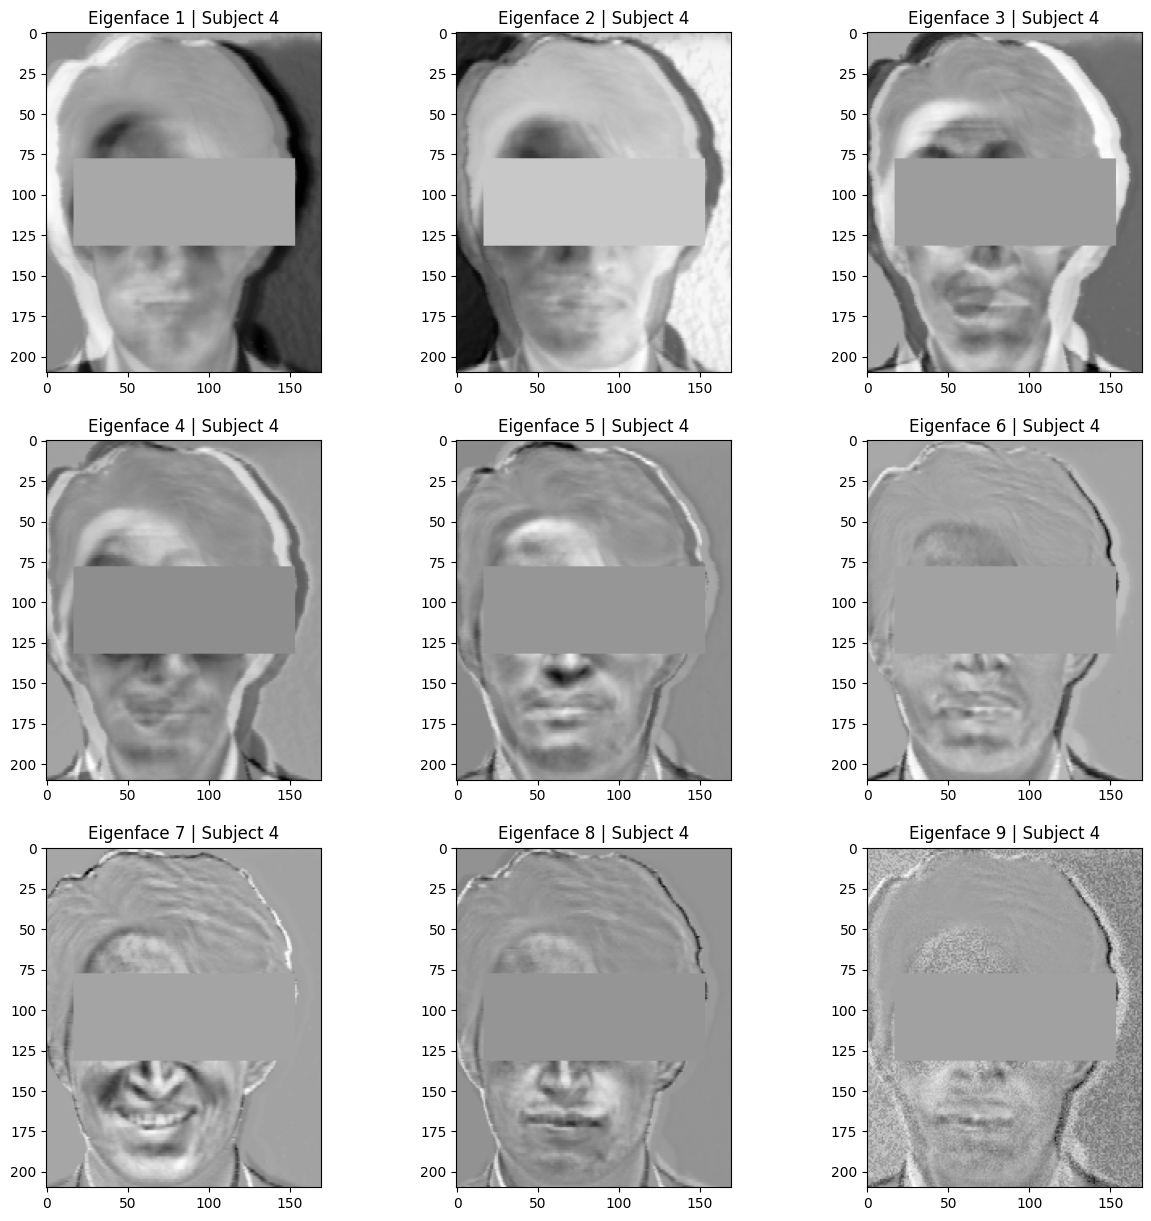

In [10]:
# # NOTE: OLD IMPLEMENTATION
# # Repeat analysis with sunglasses
# sunglasses_dir = os.path.join(cwd, 'sunglasses_faces')

# # Create sunglasses faces
# # pic_paths = [os.path.join(cwd, 'cropped', pic) for pic in os.listdir(cropped_dir)]
# # for pp in pic_paths:
# #     utils.add_sunglasses(pp)

# # Read all sunglasses images into array
# sunglasses_train_arr = utils.get_train_faces(sunglasses_dir)

# # Top 9 eigenfaces for each subject - SUNGLASSES
# n_subjects = 15
# faces_per_subject = int(sunglasses_train_arr.shape[0] / n_subjects)

# top_sunglasses_efaces = {}

# for i in range(n_subjects):
#     train_faces = sunglasses_train_arr[i*faces_per_subject : (i+1)*faces_per_subject]
#     efaces = utils.get_top_n_eigenfaces(train_faces, n=9)
#     top_sunglasses_efaces[i+1] = efaces

# # Plot some sample half-mask eigenfaces
# ix = 3
# sunglasses_efaces = top_sunglasses_efaces[3]
# Z_sunglasses = np.zeros(sunglasses_efaces.shape)
# for i in range(sunglasses_efaces.shape[0]):
#     img = sunglasses_efaces[i,:]
#     Z_sunglasses[i,:] = utils.normalize_data(img, max=255)
# utils.plot_top_9_eigenfaces(Z_sunglasses, subject=ix+1)

In [43]:
# Use top UNMASKED efaces from each subject to classify all SUNGLASSES test faces
sunglasses_test_arr = utils.get_test_faces(sunglasses_dir)

# Project SUNGLASSES test faces onto unmasked eigenface space for classification and gather accuracy
sg_to_base_dissims = utils.calc_dissimilarities_v2(top_efaces, sunglasses_test_arr, base_truth_wts, base_avg_faces)
sg_to_base_accs = utils.dissims_to_df(sg_to_base_dissims)

In [44]:
# Use top SUNGLASSES eface from each subject to classify all SUNGLASSES test faces

# Get weight vector for each subject - represents a centered training face for each SUNGLASSES subject projected into that subject's SUNGLASSES eigenface space
sunglasses_truth_arr = utils.get_weight_faces(sunglasses_dir)
sunglasses_truth_wts = utils.get_truth_weights(sunglasses_train_arr, sunglasses_truth_arr, top_sunglasses_efaces)

# Get avg face for each face used in training the eigenfaces
sunglasses_avg_faces = utils.get_avg_faces(sunglasses_train_arr, faces_per_subject)

# Calculate dissimilarities between each eigenface/test face combo
sunglasses_dissims = utils.calc_dissimilarities_v2(top_sunglasses_efaces, sunglasses_test_arr, sunglasses_truth_wts, sunglasses_avg_faces)

sunglasses_accs = utils.dissims_to_df(sunglasses_dissims)

In [11]:
# # NOTE: OLD IMPLEMENTATION
# # Use top UNMASKED eface from each subject to classify all SUNGLASSES test faces
# test_sunglasses_arr = utils.get_test_faces(sunglasses_dir)

# sim4 = utils.calc_dissimilarities(top_efaces, test_sunglasses_arr)

# accs4 = utils.clf_accs_to_df(sim4)

In [12]:
# # NOTE: OLD IMPLEMENTATION
# # Use top SUNGLASSES eface from each subject to classify all SUNGLASSES test faces
# sim5 = utils.calc_dissimilarities(top_sunglasses_efaces, test_sunglasses_arr)

# accs5 = utils.clf_accs_to_df(sim5)

c:\Users\611391\Documents\Learning\GA Tech OMSA\Classes\ISYE 6740\HW\.env\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


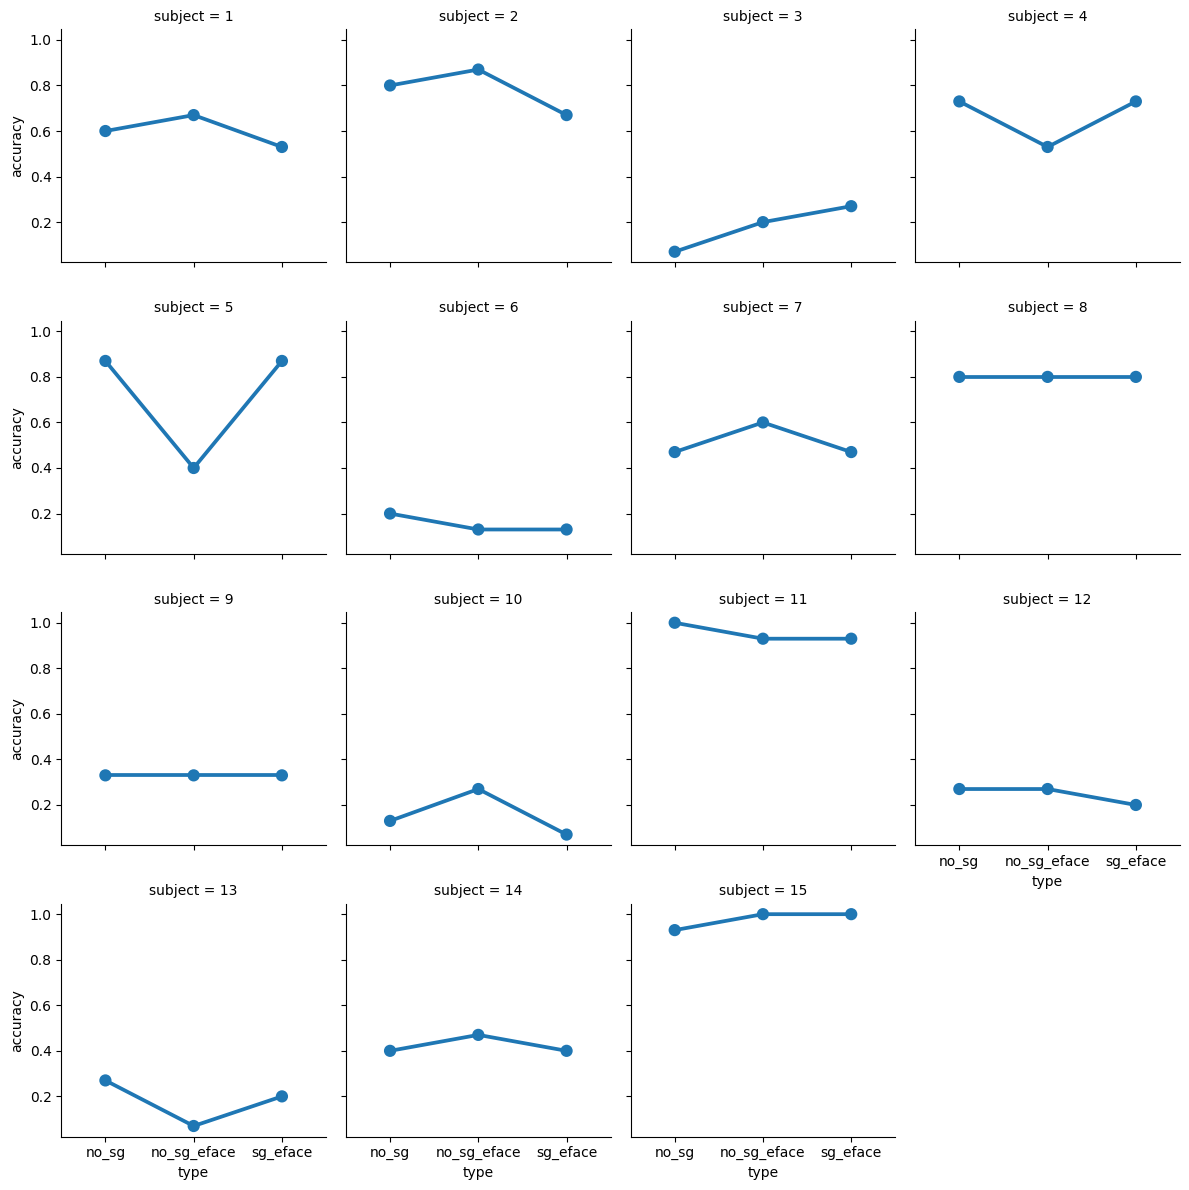

In [45]:
base_accs_g = base_accs.copy()
base_accs_g['type'] = 'no_sg'
sg_to_base_accs['type'] = 'no_sg_eface'
sunglasses_accs['type'] = 'sg_eface'
all_accs_g = pd.concat([base_accs_g, sg_to_base_accs, sunglasses_accs]).reset_index(drop=True)

g_g = sns.FacetGrid(all_accs_g, col='subject', col_wrap=4)
g_g.map(sns.pointplot, 'type', 'accuracy')

Not much difference across the board. Perhaps an analysis of prominent features for masked vs sunglasses eigenfaces is in order...

In [49]:
top_efaces[1].shape

(6, 35700)

In [62]:
# Cover 10, 20, ..., 90% of face
pic_paths = [os.path.join(cwd, 'cropped', pic) for pic in os.listdir(cropped_dir)]
n_subjects = 15
faces_per_subject = 6
m,n = (210, 170)

# Track dissimilarities
pct_dissims_df = pd.DataFrame(columns=['subject', 'accuracy', 'pct_covered'])

# Add in unobstructed dissimilarities (0% covered)
pct_base_accs = base_accs.copy()
pct_base_accs['pct_covered'] = 0
pct_base_accs.drop(columns='type', inplace=True)
pct_dissims_df = pd.concat([pct_dissims_df, pct_base_accs])

# Create top eigenface for each subject and % face covering combo
for ix,i in enumerate(range(5, 100, 5)):
    pct = i/100
    pct_dir = os.path.join(cwd, f'cover_{i}_pct_faces')
    # Create covered faces
    # if not os.path.exists(pct_dir):
    #     os.mkdir(pct_dir)
    # for pp in pic_paths:
    #     utils.cover_pct_of_face(pp, pct)

    # Read all covered images into array
    pct_train_arr = utils.get_train_faces(pct_dir)

    # Grab partially obstructed test faces
    pct_test_arr = utils.get_test_faces(pct_dir)

    # Project partially obstructed faces onto unmasked eigenface space for classification and gather accuracy
    pct_dissims = utils.calc_dissimilarities_v2(top_efaces, pct_test_arr, base_truth_wts, base_avg_faces)
    pct_accs = utils.dissims_to_df(pct_dissims)
    pct_accs['pct_covered'] = i
    pct_dissims_df = pd.concat([pct_dissims_df, pct_accs])

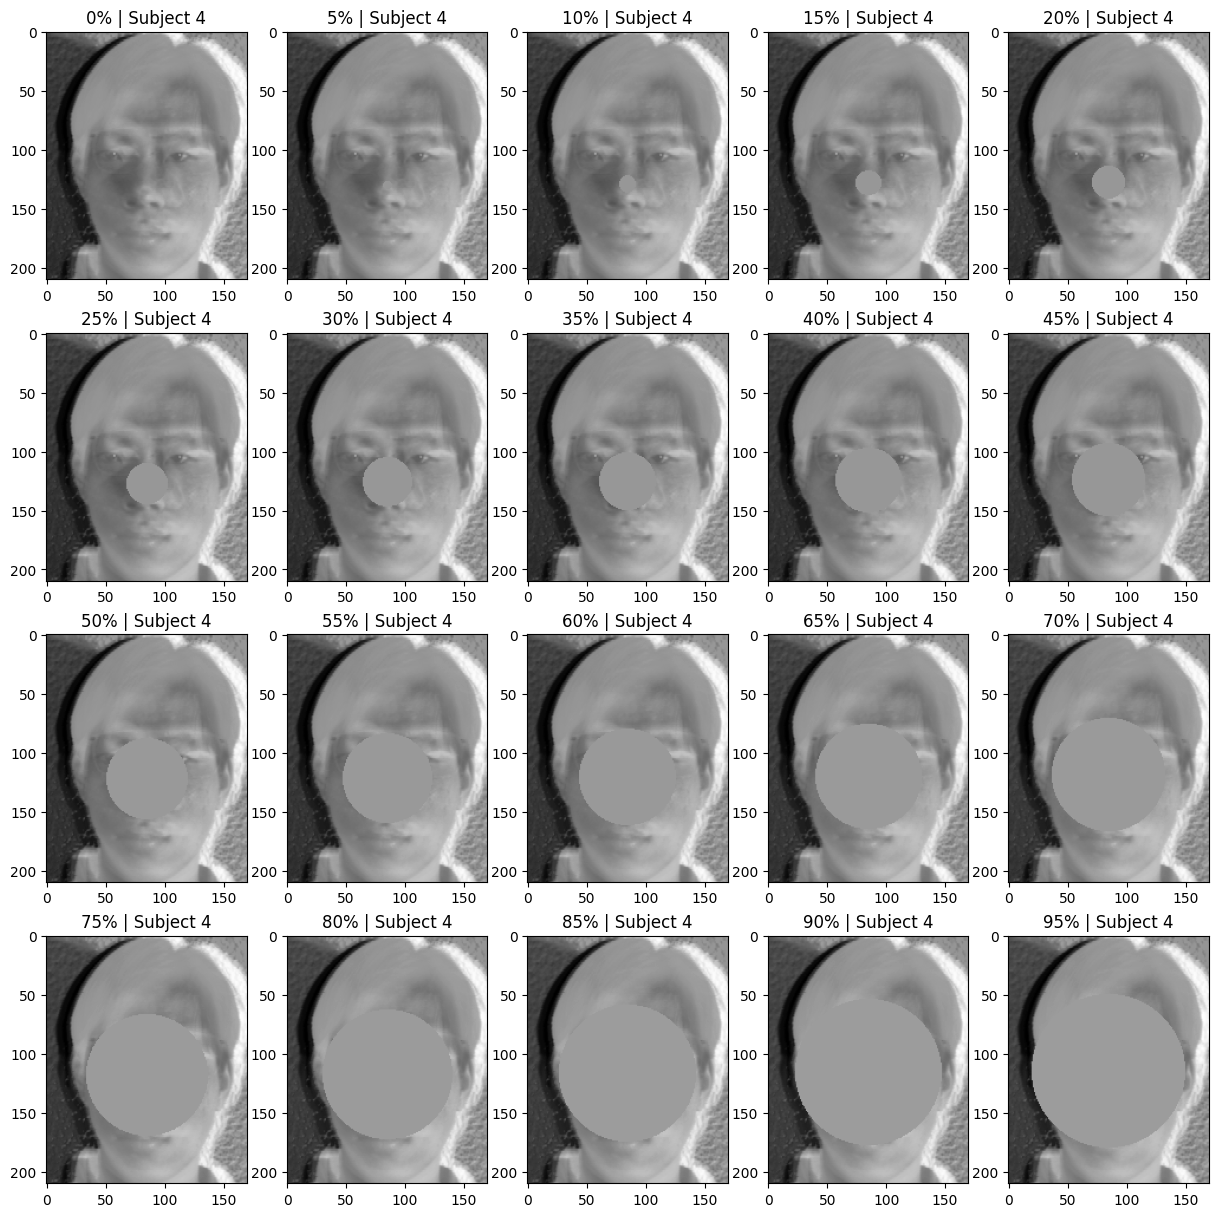

In [39]:
# # NOTE: OLD IMPLEMENTATION
# # Cover 10, 20, ..., 90% of face
# pic_paths = [os.path.join(cwd, 'cropped', pic) for pic in os.listdir(cropped_dir)]
# n_subjects = 15
# m,n = (210, 170)
# # Key = subject, val = array of 0%, 5%, 10%, ..., 95% covered TOP eigenface
# top_eface_arr = {i: np.zeros((20, 210*170)) for i in range(1, n_subjects + 1)}

# # Add unobstructed eigenface
# for k,v in top_efaces.items():
#     top_eface_arr[k][0] = v[0]

# # NOTE: THIS IS THE ONLY CODE THAT'S USED! I DON'T ACTUALLY USE THE COVERED EFACES
# # Create top eigenface for each subject and % face covering combo
# for ix,i in enumerate(range(5, 100, 5)):
#     pct = i/100
#     pct_dir = os.path.join(cwd, f'cover_{i}_pct_faces')
#     # Create covered faces
#     # if not os.path.exists(pct_dir):
#     #     os.mkdir(pct_dir)
#     # for pp in pic_paths:
#     #     utils.cover_pct_of_face(pp, pct)

#     # Read all covered images into array
#     pct_train_arr = utils.get_train_faces(pct_dir)

#     # Top 9 eigenfaces for each subject - SUNGLASSES
#     n_subjects = 15
#     faces_per_subject = int(pct_train_arr.shape[0] / n_subjects)

#     top_pct_eface = {}

#     for i in range(n_subjects):
#         train_faces = pct_train_arr[i*faces_per_subject : (i+1)*faces_per_subject]
#         eface = utils.get_top_n_eigenfaces(train_faces, n=1)
#         top_eface_arr[i+1][ix+1] = eface

# # Plot covered eigenfaces for a subject
# ix = 3
# subject = ix + 1
# pct_efaces = top_eface_arr[subject]
# _, axarr = plt.subplots(4, 5, figsize=(15,15))
# i = 0
# j = 0
# for ix in range(20):
#     normalized = utils.normalize_data(pct_efaces[ix,:], max=255)
#     pic = utils.get_im_from_arr(normalized, m=m, n=n)
#     axarr[i,j].imshow(pic, cmap='Greys_r')
#     axarr[i,j].set_title(f'{ix * 5}% | Subject {subject}')
#     if (j+1)%5==0:
#         i += 1
#         j = 0
#     else:
#         j += 1
# plt.show()

In [51]:
# # NOTE: OLD IMPLEMENTATION
# # Use top UNOBSTRUCTED eface from each subject to classify each level of OBSTRUCTED faces
# cols = ['subject', 'proj_residual_acc', 'L2_acc', 'cos_sim_acc', 'max_acc', 'avg_acc', 'median_acc', 'type']
# all_accs_o = pd.DataFrame(columns=cols)
# for i in range(5,100,5):
#     test_faces_dir = os.path.join(cwd, f'cover_{i}_pct_faces')
#     test_faces_arr = utils.get_test_faces(test_faces_dir)

#     sim = utils.calc_dissimilarities(top_efaces, test_faces_arr)
#     accs = utils.clf_accs_to_df(sim)
#     accs['pct_covered'] = i
#     all_accs_o = pd.concat([all_accs_o, accs])

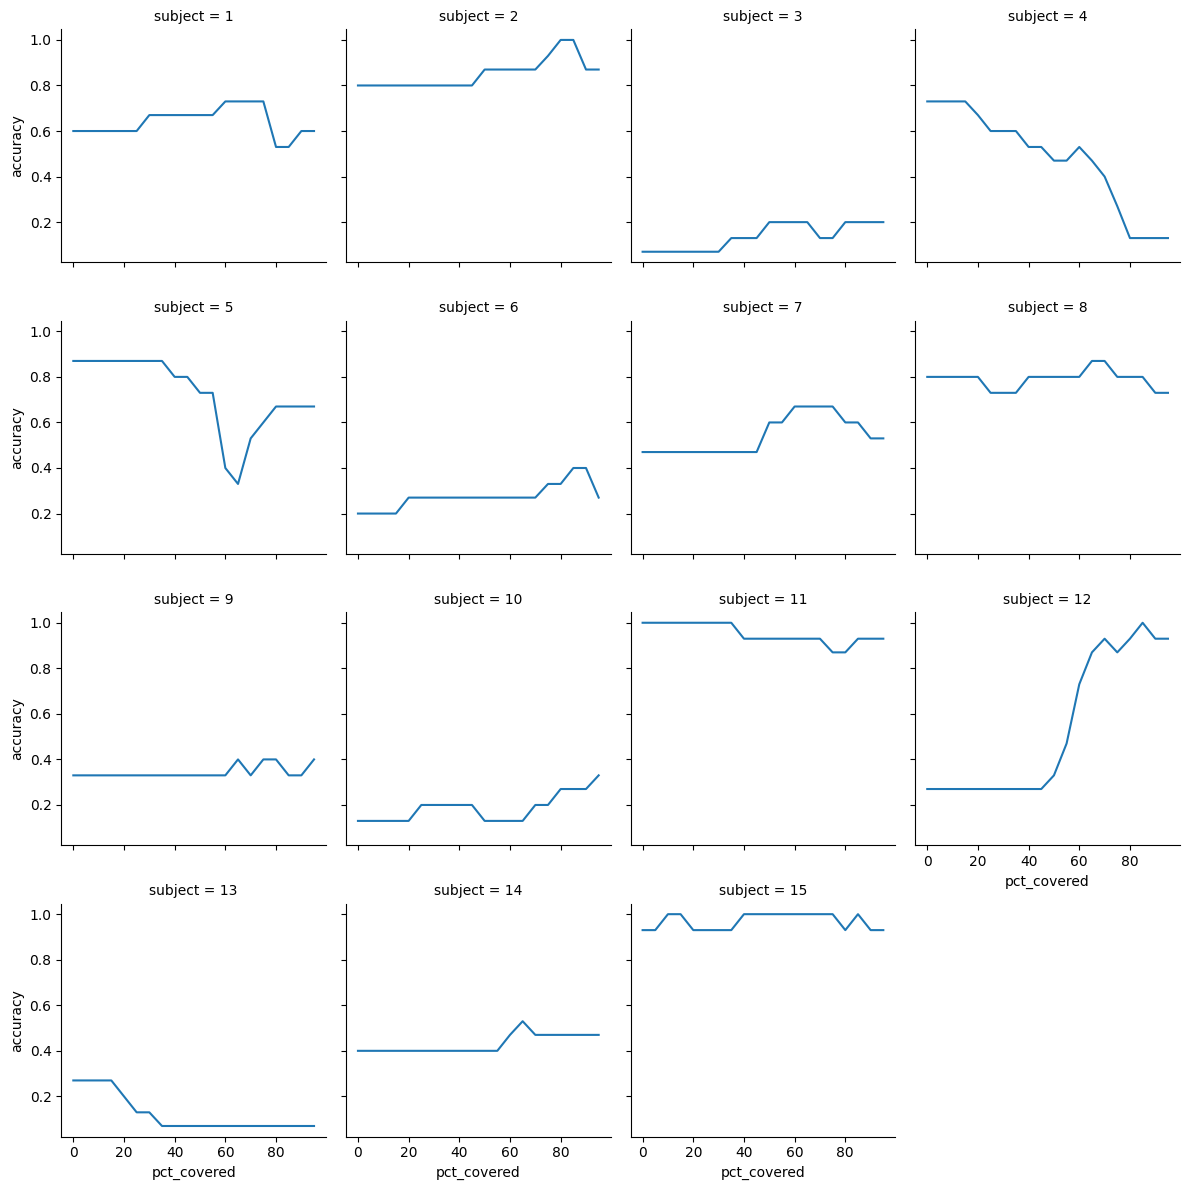

In [65]:
# Plot median and avg accuracy as % face covering increases
g_o = sns.FacetGrid(pct_dissims_df, col='subject', col_wrap=4)
g_o.map(sns.lineplot, 'pct_covered', 'accuracy')

In [64]:
# # NOTE: OLD IMPLEMENTATION
# # Plot median and avg accuracy as % face covering increases
# g_o = sns.FacetGrid(all_accs_o, col='subject', col_wrap=4)
# g_o.map(sns.lineplot, 'pct_covered', 'median_acc', color='0.3')
# g_o.map(sns.lineplot, 'pct_covered', 'avg_acc', color='#ff9f9b')

Accuracy doesn't respond much to % face covering. In most cases, the change is not drastic. For subject 4, we see the largest dropoff. For subject 12, the accuracy drastically increases with pct covering. These findings could illustrate that the features themselves might not be as important as the outline of each subject's head. There is no inflection point where accuracy suddenly changes. I would have expected covering the eyes or the mouth (at around 50-60% covering) might induce such an inflection point, but that is not the case.